In [1]:
# NB: please make supe to apply a template to experiment plates in the ui before running this code

from ldm import ldm

raw_data = ldm.get_experiment_measurements('Ring_Testrun1', label='Label1')

norm_data = ldm.normalize_values(raw_data)
norm_data_log = ldm.normalize_values(raw_data, log_value=True)

Processing plate 230602_AR_2_2
Processing plate 230602_AR_2_1
Processing plate 230602_AR_1_2
Processing plate 230602_AR_1_1

Found 960 measurements


In [2]:
z_prime = ldm.calculate_z_prime(raw_data)
z_prime_log = ldm.calculate_z_prime(raw_data, log_value=True)

In [4]:
z_prime

,plate,z_prime
0,230602_AR_1_1,0.861708
1,230602_AR_1_2,0.855297
2,230602_AR_2_1,0.848553
3,230602_AR_2_2,0.071426


In [5]:
%get raw_data
%get norm_data
%get norm_data_log
%get z_prime
%get z_prime_log

In [ ]:
library(captioner)
library(RColorBrewer)
library(lawstat)
library(ggplot2)
library(dplyr)
library(car)
library(ggpubr)

In [ ]:
# if you want to save something as a file, please save it in the /data/notebooks/ directory
# after that you can download it from the ui
write.csv(z_prime, "/data/notebooks/z.prime.csv", row.names = FALSE)

In [19]:
library(captioner)
library(RColorBrewer)
library(lawstat)
library(ggplot2)
library(dplyr)
library(bioassays)
library(car)
library(ggpubr)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: carData


Attaching package: ‘car’


The following object is masked from ‘package:dplyr’:

    recode


The following object is masked from ‘package:lawstat’:

    levene.test




In [20]:
type.pal = brewer.pal(9,"Set1")
type.pal = c(type.pal[2:1], "black", type.pal[3:9], brewer.pal(8,"Dark2"))

num_to_letter = function(number, base = 26, suffix = "") {
   number1 = number - 1
   last_digit = number1 %% base
   rest = number1 %/% base
   suffix = paste0(LETTERS[last_digit + 1], suffix)
   if (rest > 0) Recall(rest, base, suffix) else suffix
}


create_heatmap_plate_data = function(data, plate_barcode) {
  plate = data %>%  
    mutate(row = sapply(raw_data$plate_row, num_to_letter), col = raw_data$plate_column) %>% 
    filter(plate == plate_barcode) %>% 
    select(row, col, value, plate)
      return(plate)
}


create_heatmap_panel = function(raw_data) {
    unique_plates = unique(raw_data$plate)
    plate_data_list = lapply(unique_plates, function(plate_barcode) {
      create_heatmap_plate_data(raw_data, plate_barcode)
    })
    all_plate_data = do.call(rbind, plate_data_list)
    heatmap_panel = ggplot(all_plate_data, aes(x = col, y = row, fill = value)) +
      geom_tile() +
      scale_fill_gradient(low = "white", high = "red") +
      theme_minimal() +
      facet_wrap(~plate, ncol = 5) 
    return(heatmap_panel)
}

create_histogram_plot <- function(data, x_var, fill_range, title, x_label="") {
      p = ggplot(data, aes(x = !!rlang::sym(x_var))) +
        geom_histogram(aes(fill = after_stat(count)), col = 'black', alpha = .4) +
        scale_fill_gradient("Count", low = fill_range[1], high = fill_range[2]) +
        ggtitle(title) +
        labs(x = x_label, y = "Count") +
        theme_bw() +
        theme(plot.title = element_text(hjust = 0.5)) 
        return(p)
}

create_controls_plot = function(data, x_var, y_var, group_var, color_var, title="", y_label="") {
    
    p = ggplot(data, aes(x = !!rlang::sym(x_var),
                         y = !!rlang::sym(y_var),
                         group = !!rlang::sym(group_var), 
                         color = !!rlang::sym(color_var))) +
                      geom_jitter(width=0.2) + 
                      ylab(y_label) + 
                      xlab("") +
                      scale_color_manual(name="", values = type.pal, drop=F) +
                      guides(color = guide_legend(ncol=1, byrow = T)) +
                      theme(strip.text = element_text(size=10),
                            axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.5, size=rel(0.99)),
                            legend.position = "right", legend.title=element_text(size=rel(0.8)),
                            legend.text = element_text(size=rel(0.8)))
        
        
    return(p)
}

create_z_prime_plot = function(data, x_var, y_var) {
      data[, x_var] = as.factor(data[, x_var])  
      cols = brewer.pal(9,"Set1")[c(1,6,3)]

      p = ggplot(data, aes(x=!!rlang::sym(x_var), y=!!rlang::sym(y_var))) + ylab("Z'") + xlab("") +
      scale_y_continuous(limits=c(-0.5,1), expand = c(0,0))+
      geom_hline(yintercept=c(0,0.5)) +
      geom_rect(xmin=0, xmax=length(levels(data$plate))+1, ymin=-Inf, ymax=0, fill=cols[1], alpha=0.5) + 
      geom_rect(xmin=0, xmax=length(levels(data$plate))+1, ymin=0, ymax=0.5, fill=cols[2], alpha=0.5) + 
      geom_rect(xmin=0, xmax=length(levels(data$plate))+1, ymin=0.5, ymax=1, fill=cols[3], alpha=0.5) + 
      geom_point() +
      ggtitle("Z'-factor")+
      theme(axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1), 
            strip.text = element_text(size=10),
            plot.title = element_text(hjust = 0.5))

        return(p)
}

create_plate_control_bar_plot = function(data, x_var, y_var, fill_var, sd_var, x_label='') {
    
     p = ggplot(data, aes(x=!!rlang::sym(x_var), y=!!rlang::sym(y_var), fill=!!rlang::sym(fill_var))) +
      geom_bar(position=position_dodge(), stat="identity",
                 #colour="black", # Use black outlines,
                 size=.3) +
        geom_errorbar(aes(ymin=!!rlang::sym(y_var)-!!rlang::sym(sd_var), ymax=!!rlang::sym(y_var)+!!rlang::sym(sd_var)),
                      linewidth=.3,    # Thinner lines
                      width=.2,
                      position=position_dodge(.9)) +
        scale_fill_manual(values=type.pal, drop=F) +
        xlab(x_label) +
        ylab("Normalized Values") +
        ggtitle("") +
        theme_bw() +
        theme(axis.text.x = element_text(angle = 90, hjust = 1,vjust = 0.5)) +
        facet_wrap(~plate, ncol=10, scales="free")
                      
      return(p)
                      }



In [21]:
options(repr.plot.width=15, repr.plot.height=8)

# Plate Heatmap

Plate heatmap of all raw luminescence values in a colour scale from green (low viability) to red (high viability) (figure 1).

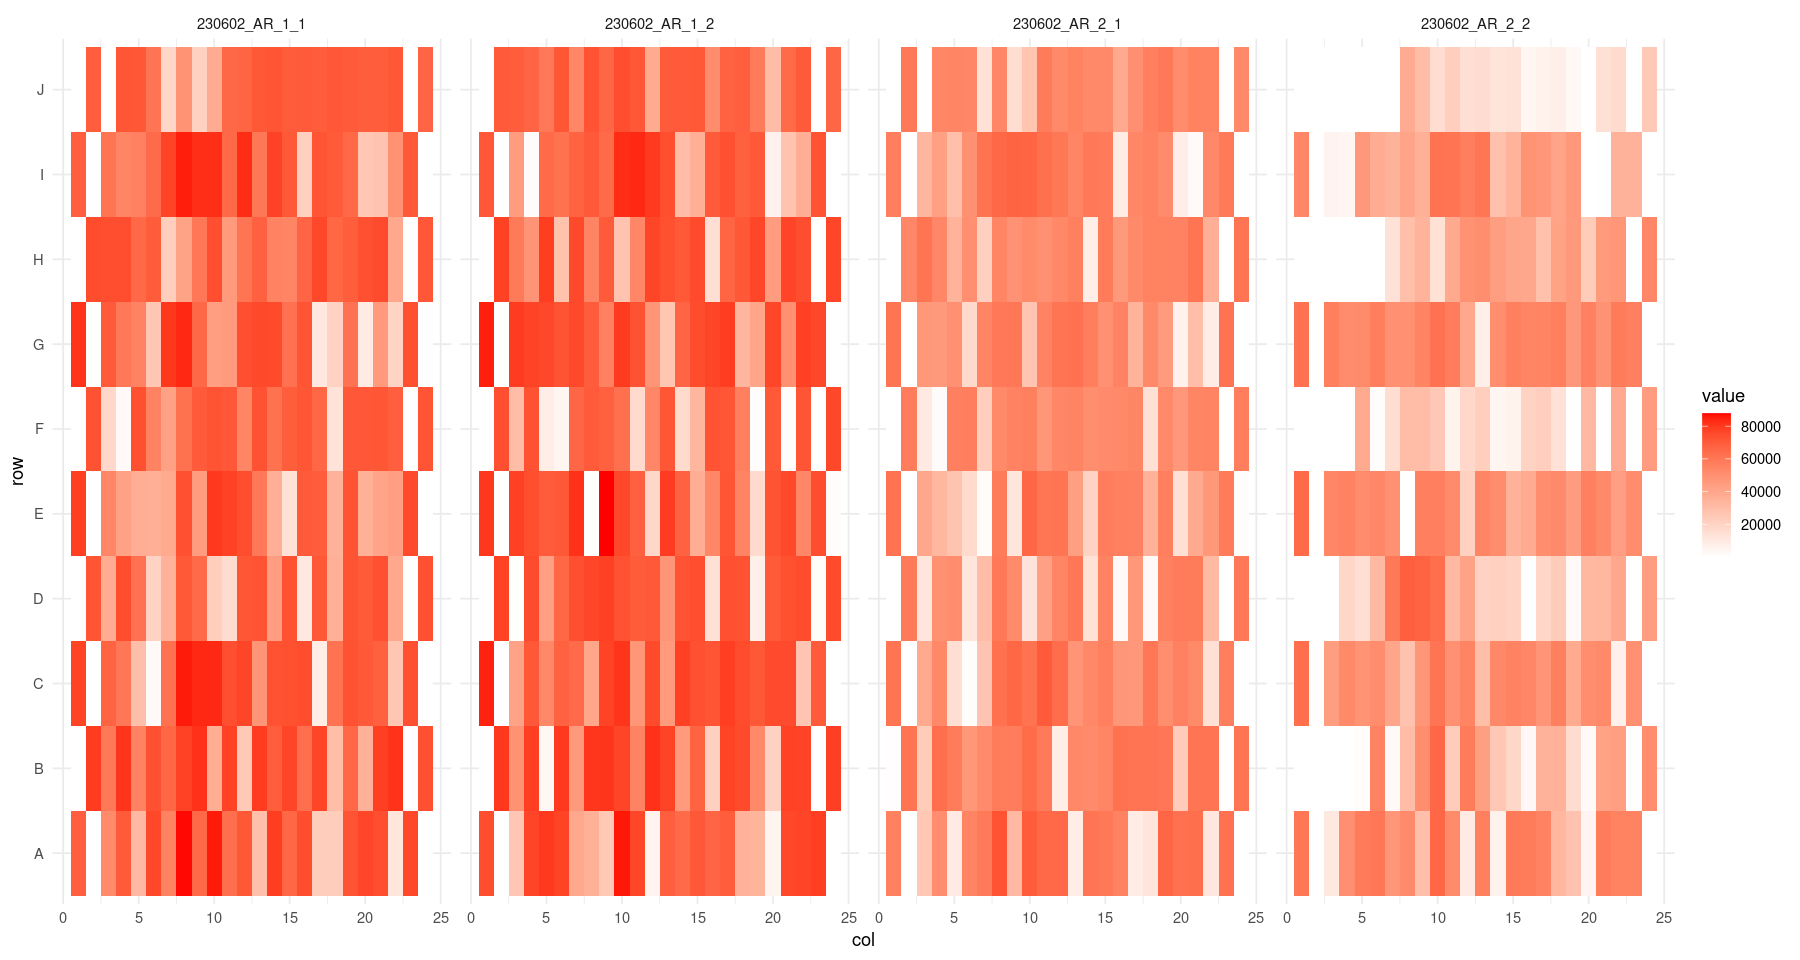

In [22]:
create_heatmap_panel(raw_data)

# Data Distribution

Histograms of raw- and NPI-normalized data for each plate (figure 2).


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


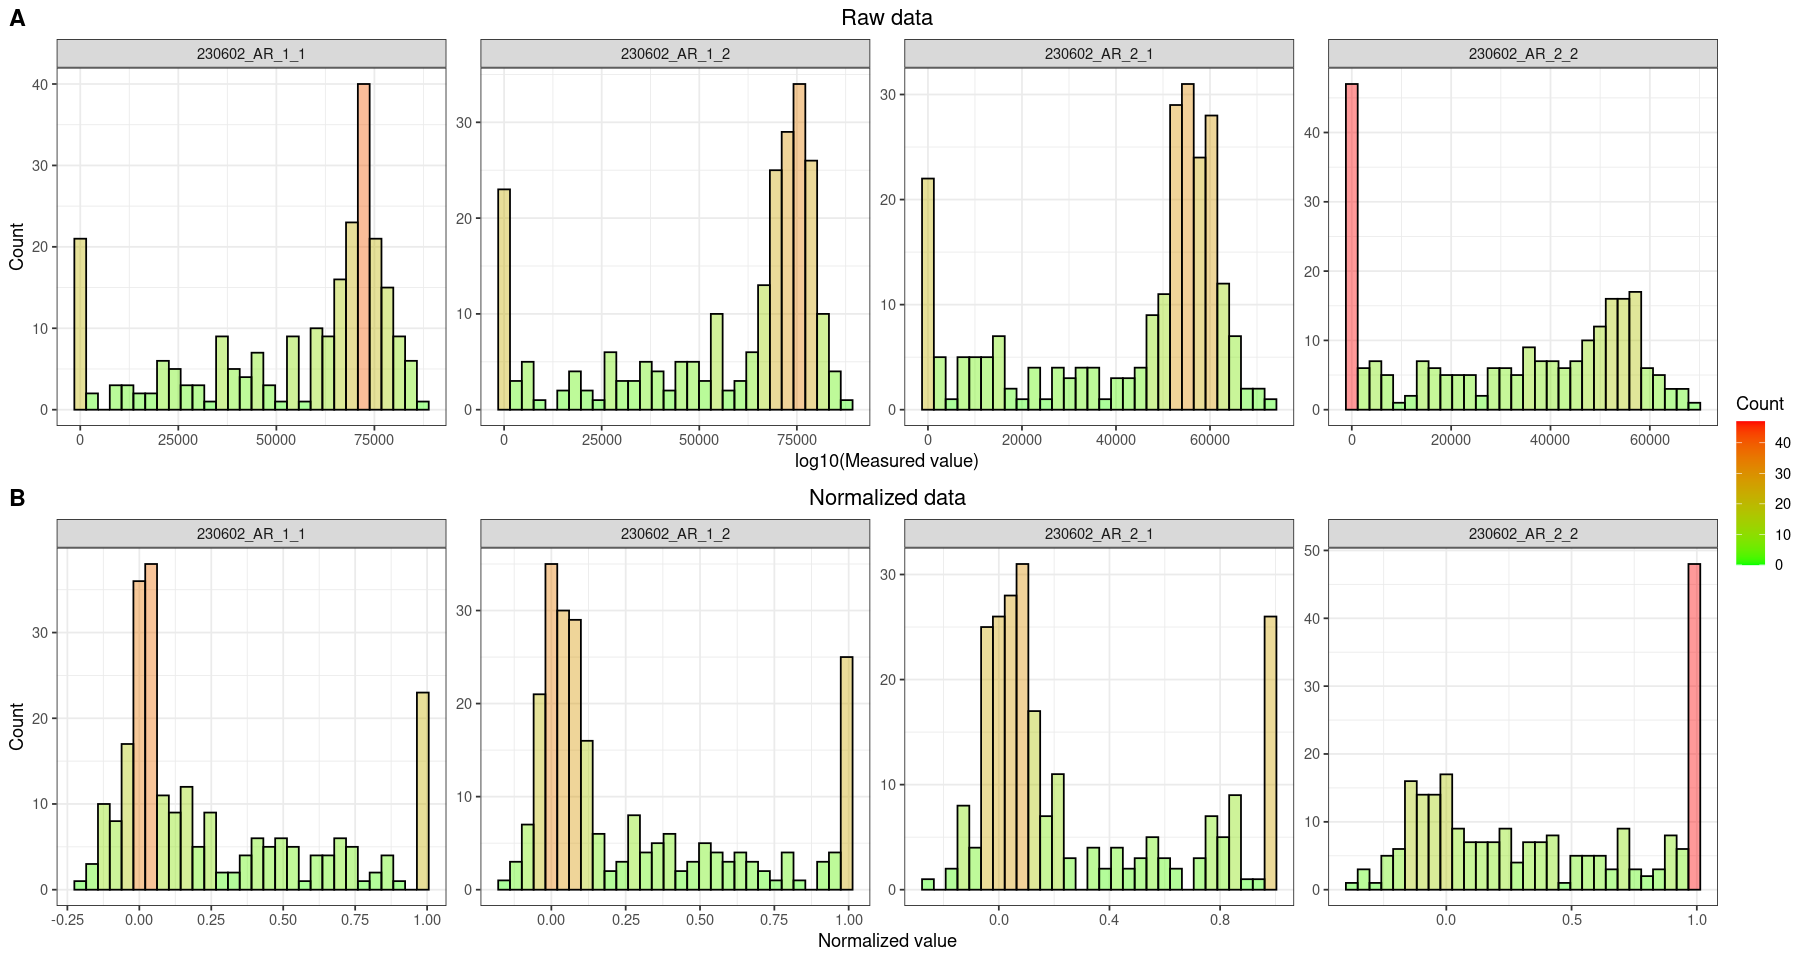

In [23]:
hist_raw = create_histogram_plot(data = norm_data, "value",  c("green", "red"),"Raw data", "log10(Measured value)")
hist_raw = hist_raw + facet_wrap(~plate, ncol=8, scales="free")
hist_norm = create_histogram_plot(data = norm_data,"norm", c("green", "red"), "Normalized data", "Normalized value")
hist_norm = hist_norm + facet_wrap(~plate, ncol=8, scales="free")

combined_hist = ggarrange(hist_raw, hist_norm, ncol = 1, labels = "AUTO", common.legend = T, legend = "right")
combined_hist

# Controls
Controlplot before- and after robust normalization (median and MAD) (figure 3).


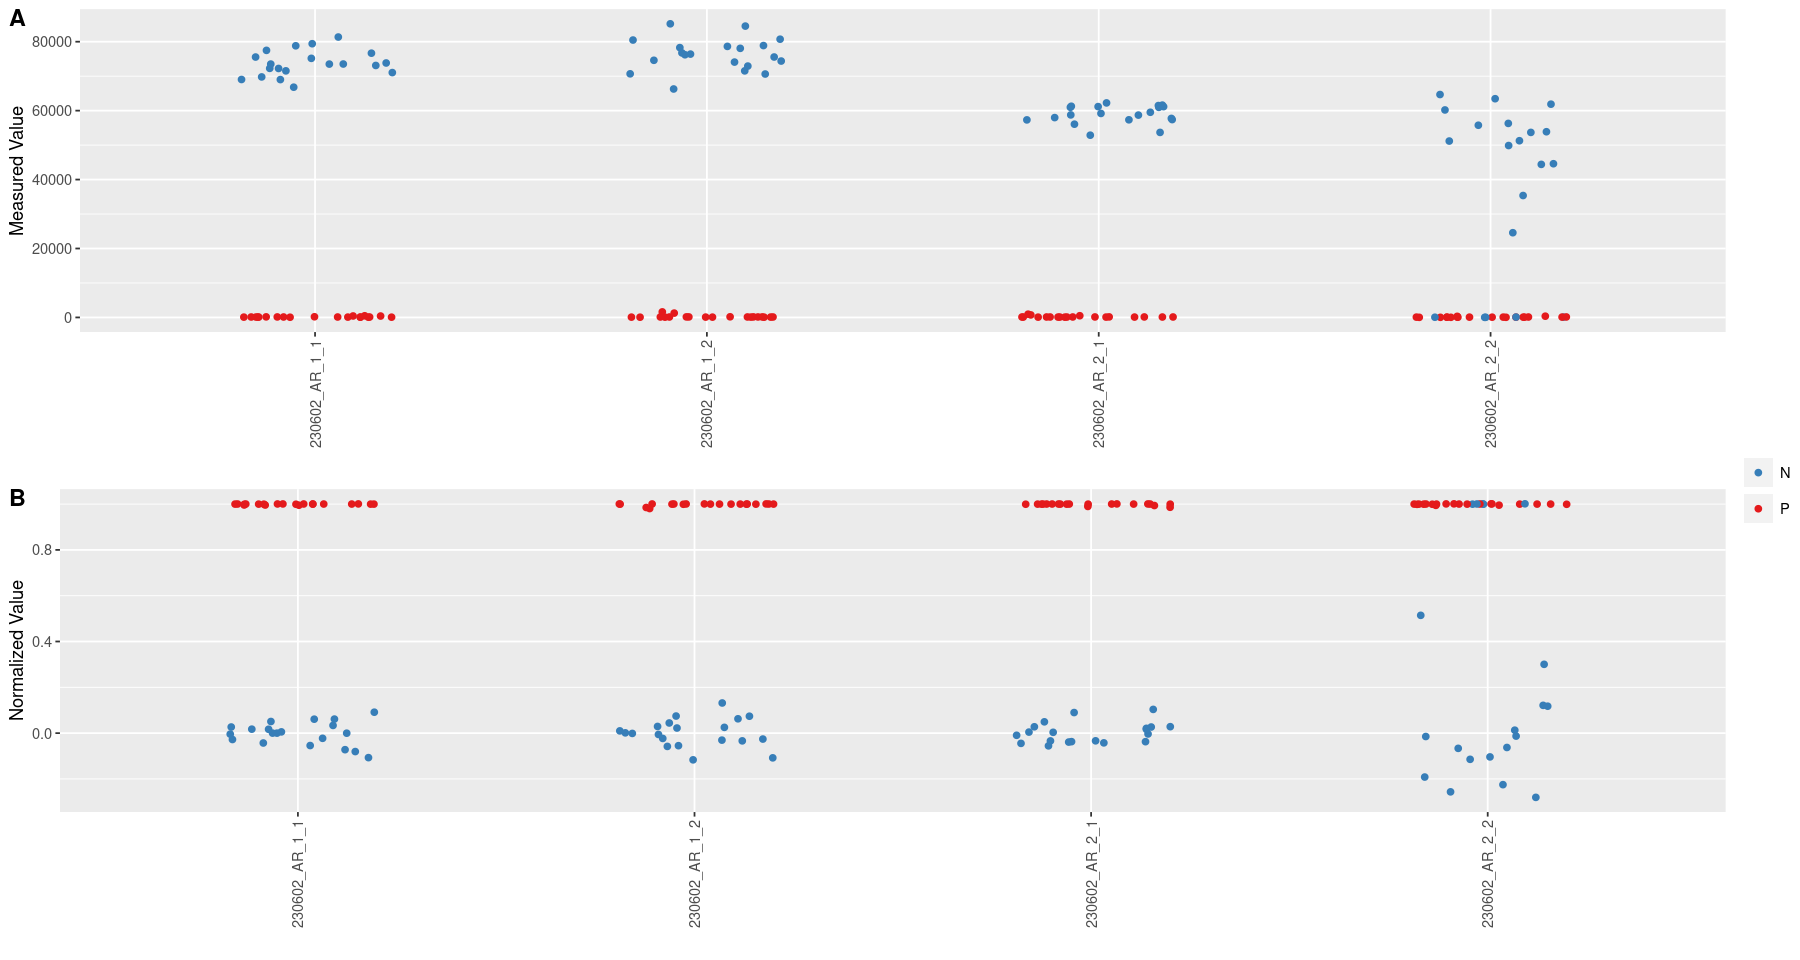

In [24]:
condat = droplevels(subset(norm_data, norm_data$control != 'C' & norm_data$control != 'empty'))
controls_raw = create_controls_plot(condat, 'plate', 'value', 'control', 'control', "", "Measured Value")
controls_norm = create_controls_plot(condat, 'plate', 'norm', 'control', 'control', "", "Normalized Value")

combined_controls = ggarrange(controls_raw, controls_norm, ncol = 1, labels = "AUTO", common.legend = T, legend = "right")
combined_controls

# Z-factor
The Z-prime or Z-factor is a value that reflects how well the negative and positive controls are separated, and is a measure of statistical effect size. For single-point high-throughput screens, a Z'>0.5 indicates a good quality assay. The Z-primes are calculated using median/MAD (robust statistics) to have an increased tolerance for potential outliers. With highly complex biological models and complex assay readouts or when a strong control condition is not known, this value may be too stringent. In general, organoid-based assays often result in a Z'>0.2. For more information on the Z': https://en.wikipedia.org/wiki/Z-factor (figure 4).


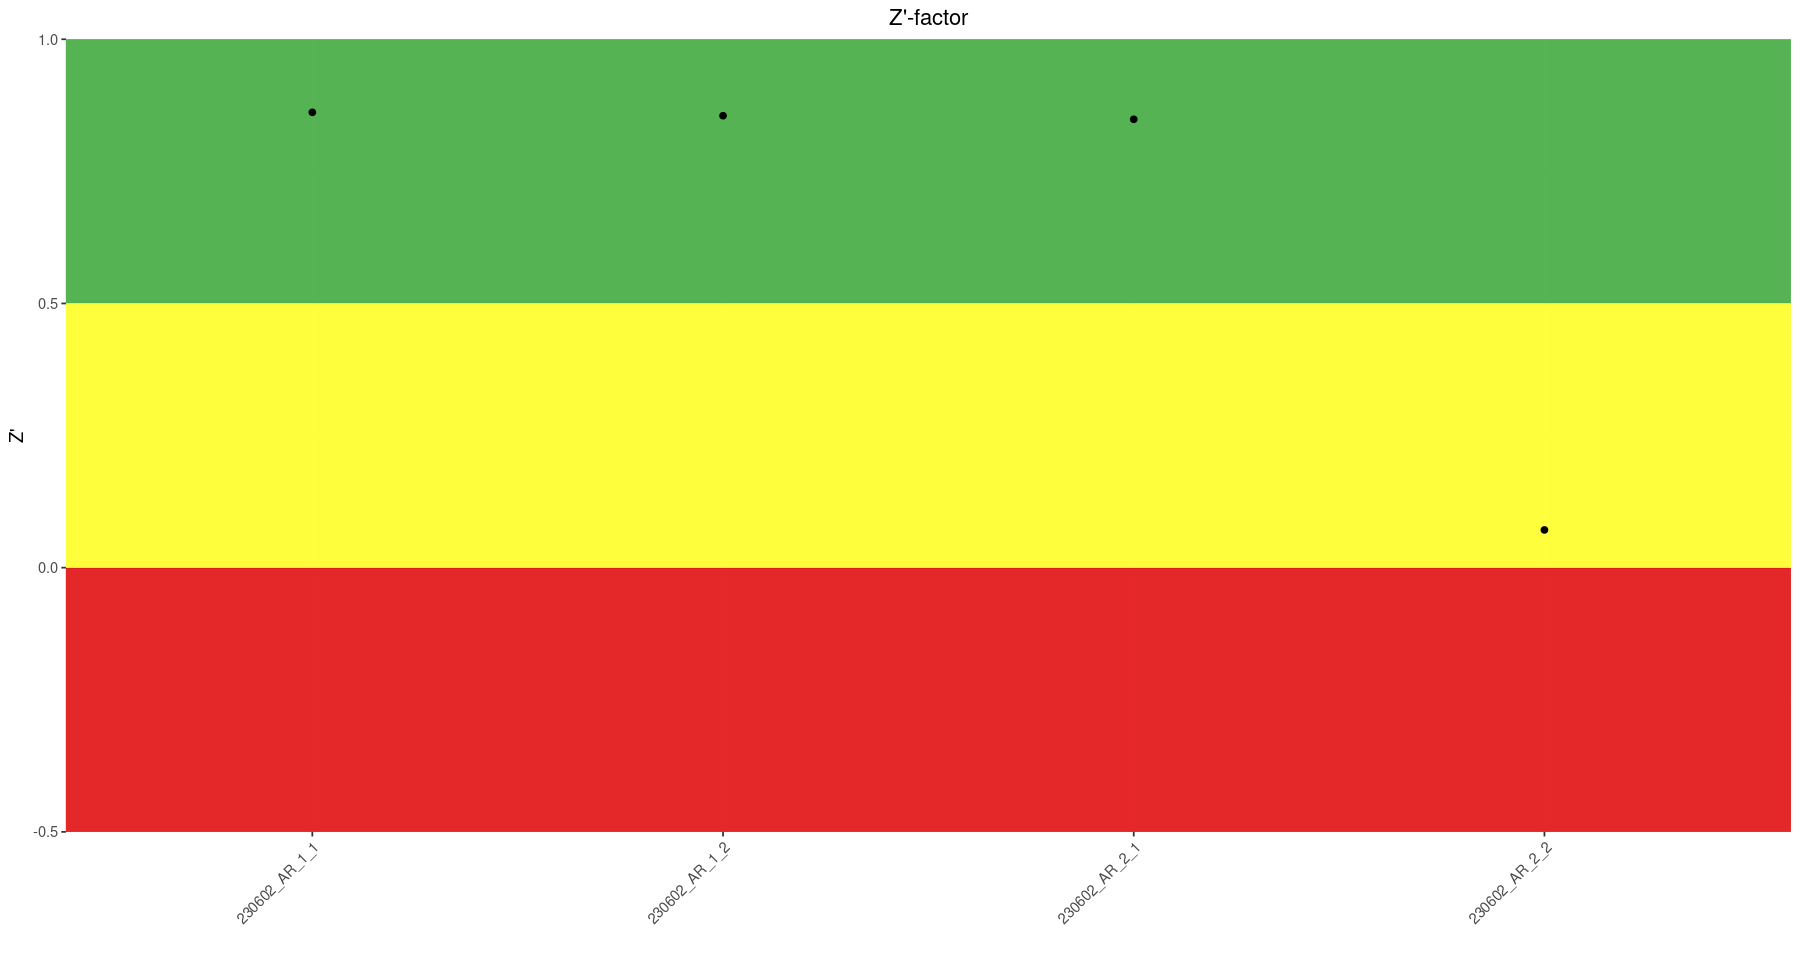

In [25]:
z_plot = create_z_prime_plot(z_prime, 'plate', 'z_prime')
z_plot

# Mean Data
Bar charts of raw- and NPI normalized data per control condition (figure 5). 


Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


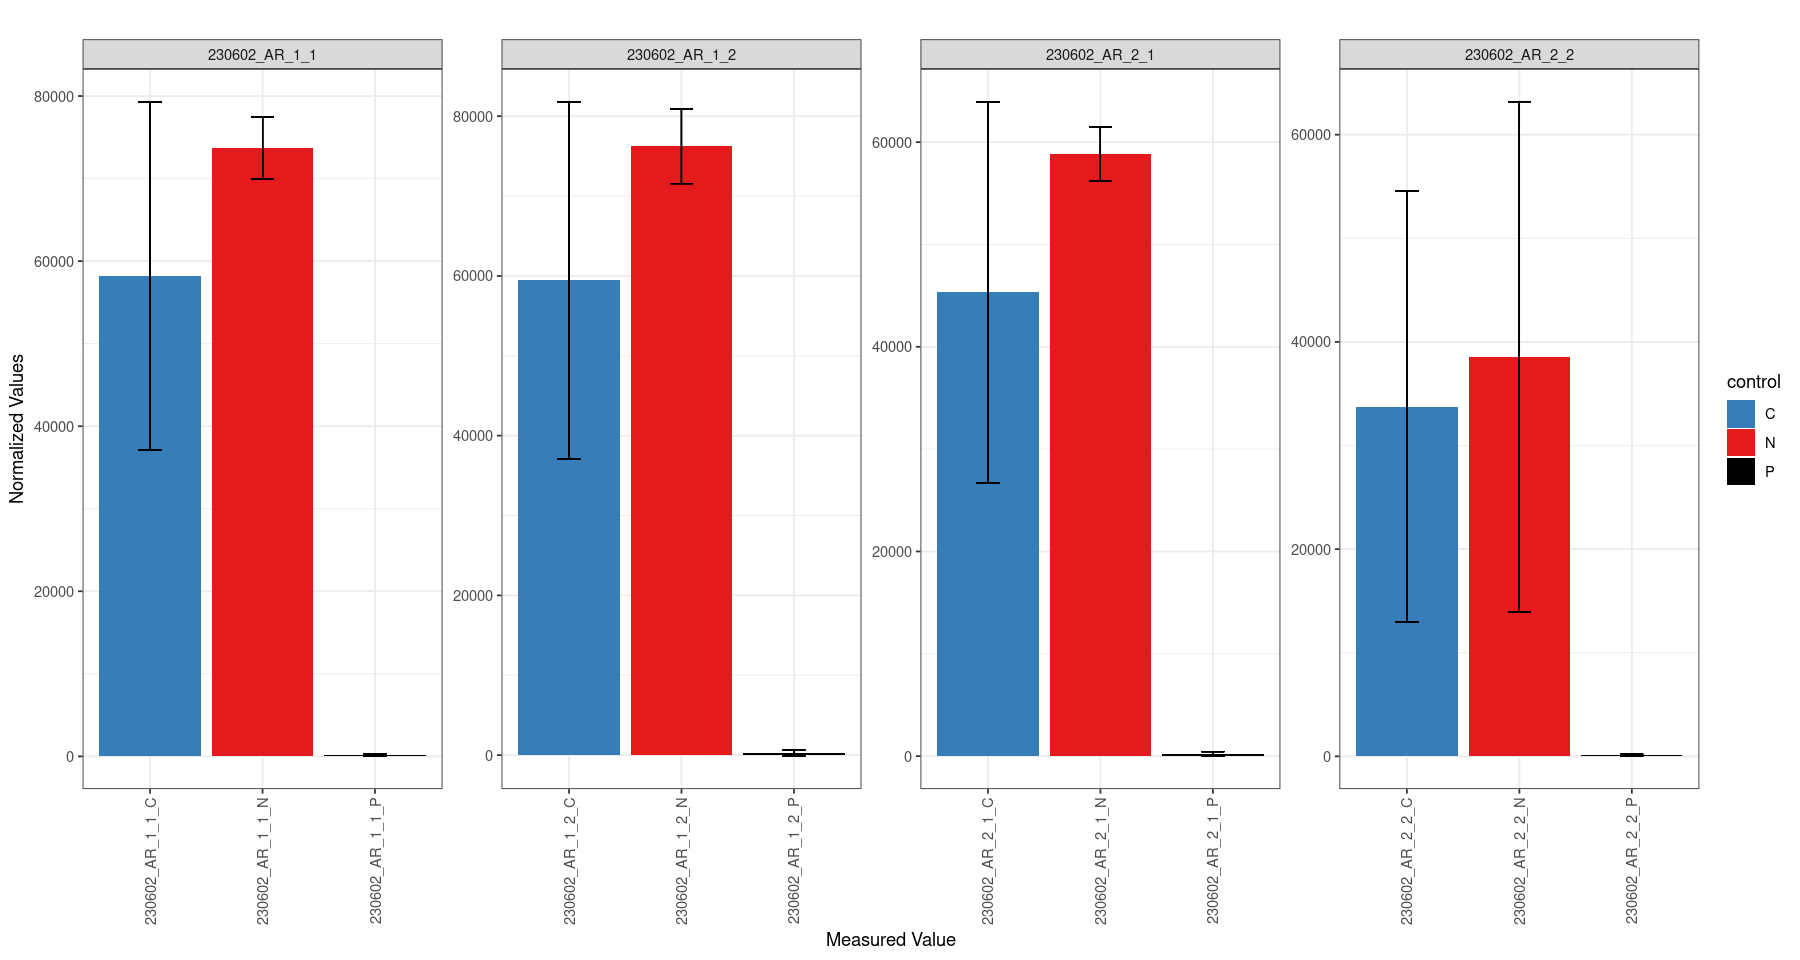

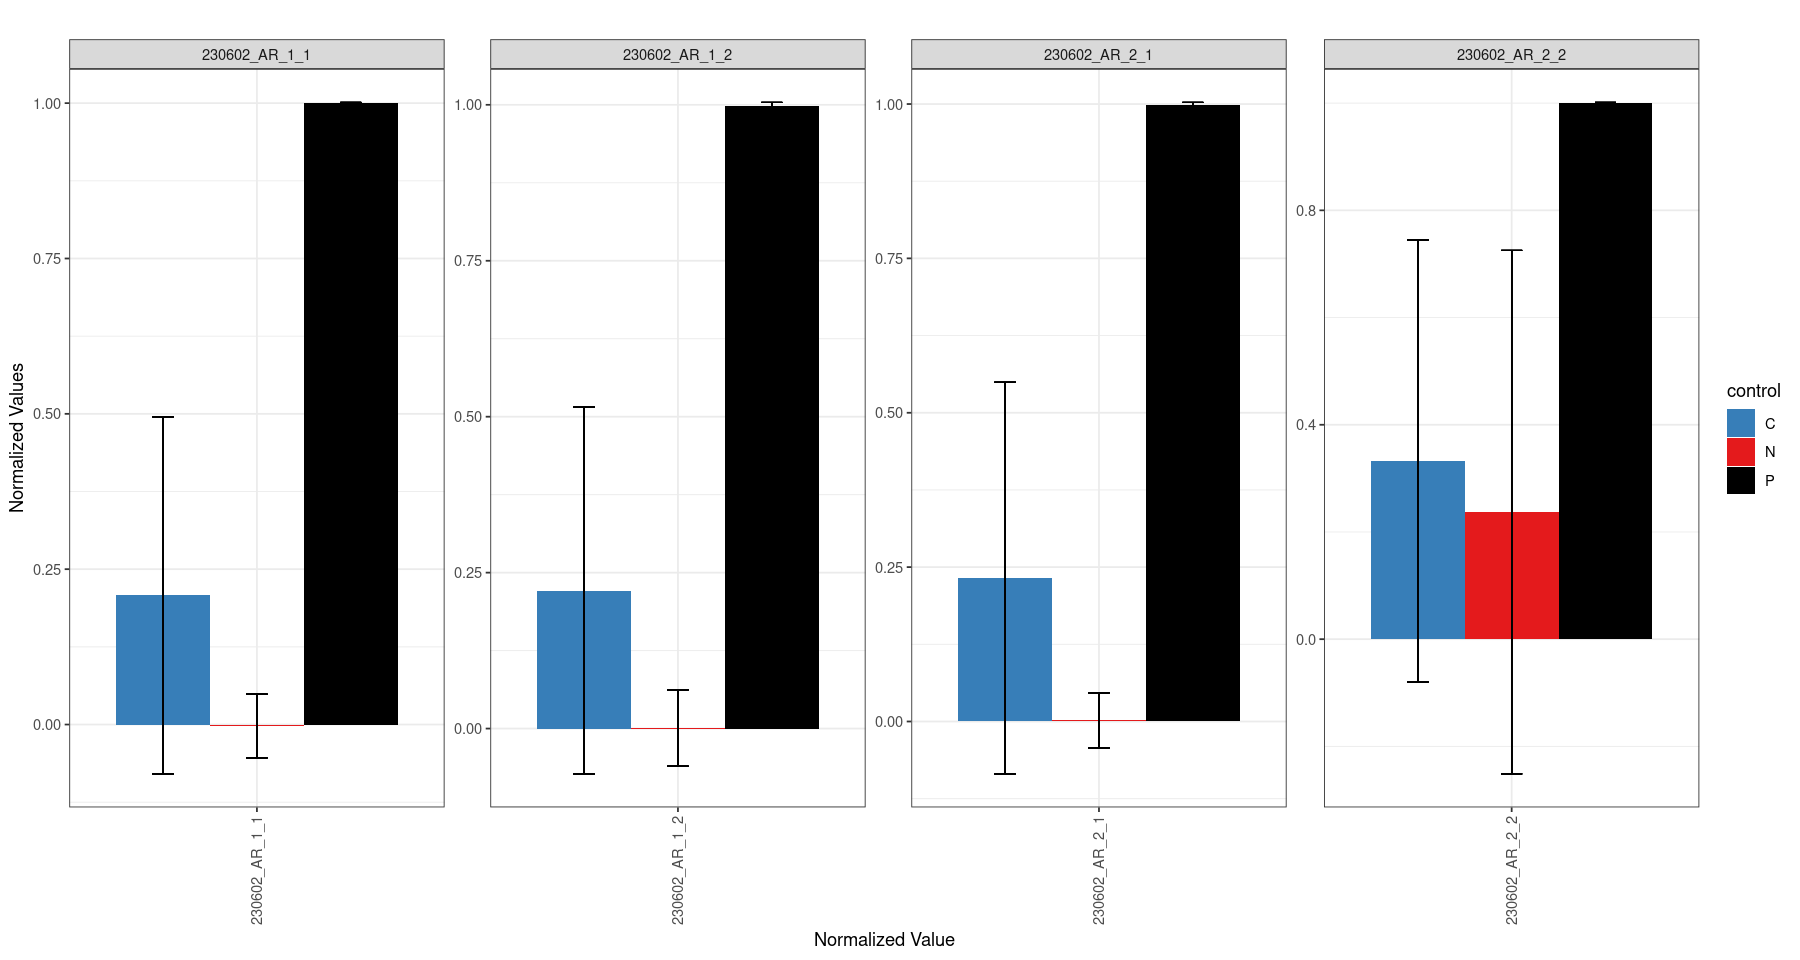

In [26]:
condat = norm_data %>% filter(control != 'empty') %>%
    mutate(X.Axis = paste(plate, control, sep = "_")) 

mean_sd =  condat %>% 
    group_by(X.Axis) %>% 
    summarize(value_mean = mean(value), value_sd=sd(value), norm_mean=mean(norm), norm_sd=sd(norm))

res_df = left_join(condat, mean_sd, by="X.Axis")


plate_barplot_raw = create_plate_control_bar_plot(res_df, 'X.Axis', 'value_mean', 'control', 'value_sd', 'Measured Value')
plate_barplot_norm = create_plate_control_bar_plot(res_df, 'plate', 'norm_mean', 'control', 'norm_sd', 'Normalized Value')

plate_barplot_raw
plate_barplot_norm



In [ ]:
# https://stackoverflow.com/questions/49907455/hide-code-when-exporting-jupyter-notebook-to-html